In [20]:
from model import *

In [21]:
traj = md.load('../../xtc_files/50000eql2.xtc', top='../../xtc_files/conf.gro')


In [22]:
# converting traj as traj with only 50 frames
traj=traj[0:50]

In [23]:
# creating the frame feature matrix
nframes = traj.xyz.shape[0]
natoms=traj.topology.residue(0).n_atoms
nmols=traj.topology.n_residues
frame_feature=[]
for i in range(nframes):
    com_pos=[] # position of Center of Mass of each molecule
    for res in range(nmols):
        com_pos.append(traj.xyz[i][res*natoms:(res+1)*natoms].mean(axis=0))
    frame_feature.append(com_pos)
frame_feature=np.array(frame_feature)
print(frame_feature.shape)

(50, 592, 3)


In [24]:
# creating the edge index matrix
cutoff=0.5
all_edge_list=[]
for i in range(nframes):
    fromlist=[]
    tolist=[]
    for j in range(nmols):
        for k in range(j+1,nmols):
            if np.linalg.norm(frame_feature[i][j]-frame_feature[i][k])<cutoff:
                fromlist.append(j)
                tolist.append(k)
                tolist.append(j)
                fromlist.append(k)
    edgelist=np.array([fromlist,tolist]).astype(np.int64)
    all_edge_list.append(edgelist)
print(len(all_edge_list))

50


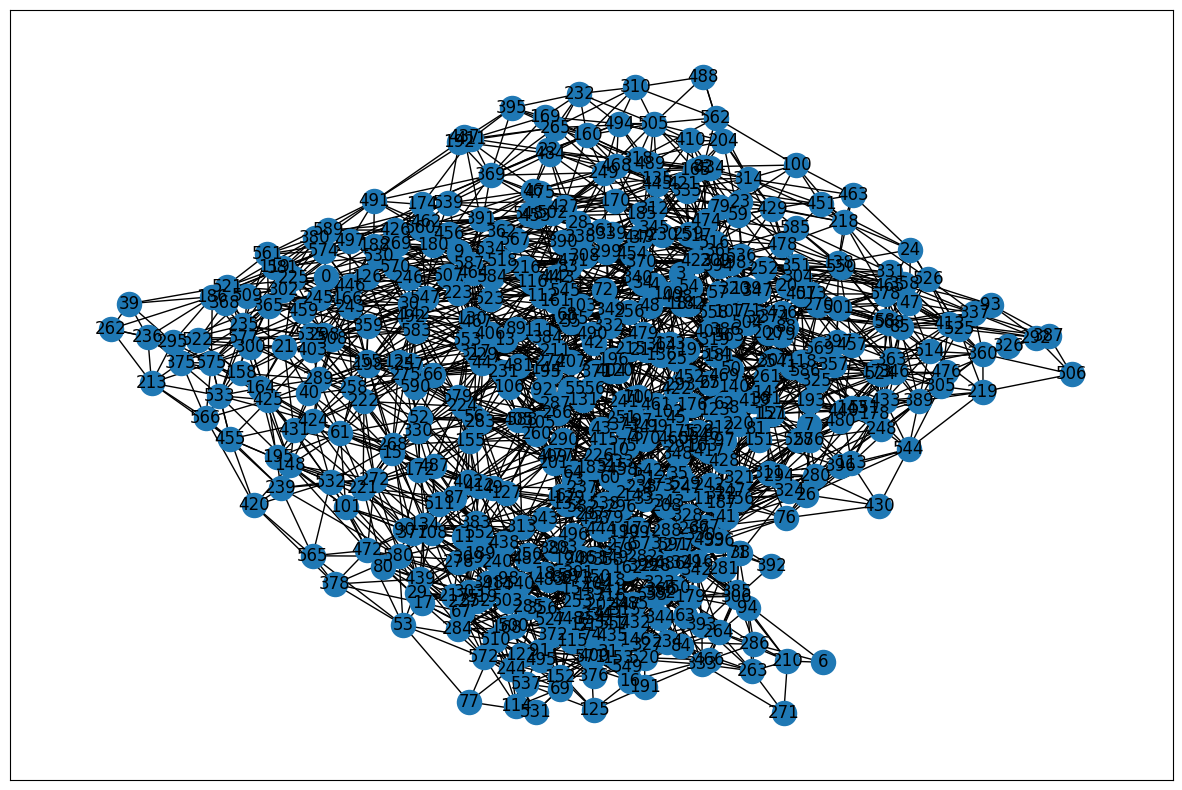

In [25]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index
frame = 10
plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=592)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)

In [26]:
graphs = []
for frame in range(nframes):
    g = data.Data(x=torch.tensor(frame_feature[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

Data(x=[592, 3], edge_index=[2, 8126], y=[1])


In [27]:
# import model.
from model import *

In [28]:
input_dim = graphs[0].num_features
output_dim = 2
lr=1e-4
epochs=100
batch_size=1
model=VGAE(VariationalGCNEncoder(input_dim, output_dim),
           VariationalGCNDecoder(output_dim,input_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [29]:
from pytorch3d.loss import chamfer_distance

In [30]:
train_loader_set = DataLoader(graphs[:int(nframes*0.6)], batch_size=batch_size, shuffle=True)
validation_loader_set = DataLoader(graphs[int(nframes*0.6):int(nframes*0.8)], batch_size=batch_size, shuffle=True)
test_loader_set = DataLoader(graphs[int(nframes*0.8):], batch_size=batch_size, shuffle=True)

In [31]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in train_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()

        

    return loss_all / len(train_loader_set.dataset),closs_all/len(train_loader_set.dataset), feature_loss_all / len(train_loader_set.dataset), edge_loss_all / len(train_loader_set.dataset), kl_loss_all / len(train_loader_set.dataset)

In [32]:
total_train_losses = []
feature_train_losses = []
edge_train_losses = []
kl_train_losses = []
closs_train_losses=[]

# validation will be done after training
# training done now
for epoch in range(1,epochs+1):
    tloss,cdloss,floss,eloss,klloss = train()
    print(f'Epoch: {epoch:03d}')
    print(f'Train Loss: {tloss:.4f}, Chamfer Loss: {cdloss:.4f}, Feature Loss: {floss:.4f}, Edge Loss: {eloss:.4f}, KL Loss: {klloss:.4f}')
    total_train_losses.append(tloss)
    feature_train_losses.append(floss)
    edge_train_losses.append(eloss)
    kl_train_losses.append(klloss)
    closs_train_losses.append(cdloss)


/tmp/ipykernel_5593/1287167025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)


Epoch: 001
Train Loss: 7.8403, Chamfer Loss: 5.6739, Feature Loss: 2.1664, Edge Loss: 0.0000, KL Loss: 0.0001
Epoch: 002
Train Loss: 7.6562, Chamfer Loss: 5.5158, Feature Loss: 2.1404, Edge Loss: 0.0000, KL Loss: 0.0001
Epoch: 003
Train Loss: 7.5203, Chamfer Loss: 5.4016, Feature Loss: 2.1187, Edge Loss: 0.0000, KL Loss: 0.0001
Epoch: 004
Train Loss: 7.4096, Chamfer Loss: 5.3231, Feature Loss: 2.0865, Edge Loss: 0.0000, KL Loss: 0.0001
Epoch: 005
Train Loss: 7.2654, Chamfer Loss: 5.1932, Feature Loss: 2.0723, Edge Loss: 0.0000, KL Loss: 0.0002
Epoch: 006
Train Loss: 7.0869, Chamfer Loss: 5.0473, Feature Loss: 2.0395, Edge Loss: 0.0000, KL Loss: 0.0002
Epoch: 007
Train Loss: 6.9505, Chamfer Loss: 4.9391, Feature Loss: 2.0114, Edge Loss: 0.0000, KL Loss: 0.0002
Epoch: 008
Train Loss: 6.8291, Chamfer Loss: 4.8466, Feature Loss: 1.9825, Edge Loss: 0.0000, KL Loss: 0.0002
Epoch: 009
Train Loss: 6.6590, Chamfer Loss: 4.7061, Feature Loss: 1.9529, Edge Loss: 0.0000, KL Loss: 0.0003
Epoch: 010

In [33]:
# writing a validate function
def validate():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in validation_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss + closs
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)
        closs_all+=float(closs)
    return loss_all / len(validation_loader_set.dataset),closs_all/len(validation_loader_set.dataset), feature_loss_all / len(validation_loader_set.dataset), edge_loss_all / len(validation_loader_set.dataset), kl_loss_all / len(validation_loader_set.dataset)

In [34]:
# validating the model 
total_val_losses = []
feature_val_losses = []
edge_val_losses = []
kl_val_losses = []
closs_val_losses=[]
for epoch in range(1,epochs+1):
    vtloss,vcdloss,vfloss,veloss,vklloss = validate()
    print(f'Epoch: {epoch:03d}')
    print(f'Validation Loss: {vtloss:.4f}, Chamfer Loss: {vcdloss:.4f}, Feature Loss: {vfloss:.4f}, Edge Loss: {veloss:.4f}, KL Loss: {vklloss:.4f}')
    total_val_losses.append(vtloss)
    feature_val_losses.append(vfloss)
    edge_val_losses.append(veloss)
    kl_val_losses.append(vklloss)
    closs_val_losses.append(vcdloss)
    

Epoch: 001
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027
Epoch: 002
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027


/tmp/ipykernel_5593/3429122802.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)


Epoch: 003
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027
Epoch: 004
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027
Epoch: 005
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027
Epoch: 006
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027
Epoch: 007
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027
Epoch: 008
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027
Epoch: 009
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027
Epoch: 010
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, Edge Loss: 0.0000, KL Loss: 0.0027
Epoch: 011
Validation Loss: 1.4307, Chamfer Loss: 1.0017, Feature Loss: 0.4290, 

In [60]:
# test function 
input_feature=[]    
decoded_feature=[]
def test():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in test_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        input_feature.append(data.x)
        decoded_feature.append(data.x)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss + closs
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)
        closs_all+=float(closs)
    return loss_all / len(test_loader_set.dataset),closs_all/len(test_loader_set.dataset), feature_loss_all / len(test_loader_set.dataset), edge_loss_all / len(test_loader_set.dataset), kl_loss_all / len(test_loader_set.dataset)

In [61]:
# testing the model
total_test_losses = []
feature_test_losses = []
edge_test_losses = []
kl_test_losses = []
closs_test_losses=[]
for epoch in range(1,epochs+1):
    ttloss,tcdloss,tfloss,teloss,tklloss = test()
    print(f'Epoch: {epoch:03d}')
    print(f'Test Loss: {ttloss:.4f}, Chamfer Loss: {tcdloss:.4f}, Feature Loss: {tfloss:.4f}, Edge Loss: {teloss:.4f}, KL Loss: {tklloss:.4f}')
    total_test_losses.append(ttloss)
    feature_test_losses.append(tfloss)
    edge_test_losses.append(teloss)
    kl_test_losses.append(tklloss)
    closs_test_losses.append(tcdloss)

RuntimeError: expected scalar type Float but found Double

In [58]:
# test function 
def errorcalc():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    embeddings=[]
    input_feature=[]
    decoded_feature=[]
    for data in test_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        embeddings.append(z)
        decoded_feature.append(decoded_x)
        input_feature.append(data.x)
        error = lossFxn(decoded_x, data.x)
        error_all+=float(error)
    return error_all/ len(test_loader_set.dataset)

In [59]:
errors =[]
for epoch in range(1,epochs+1):
    error1 = errorcalc()
    print(f'Epoch: {epoch:03d}')
    print(f'Error: {error1:.4f}')
    errors.append(error1)

RuntimeError: expected scalar type Float but found Double

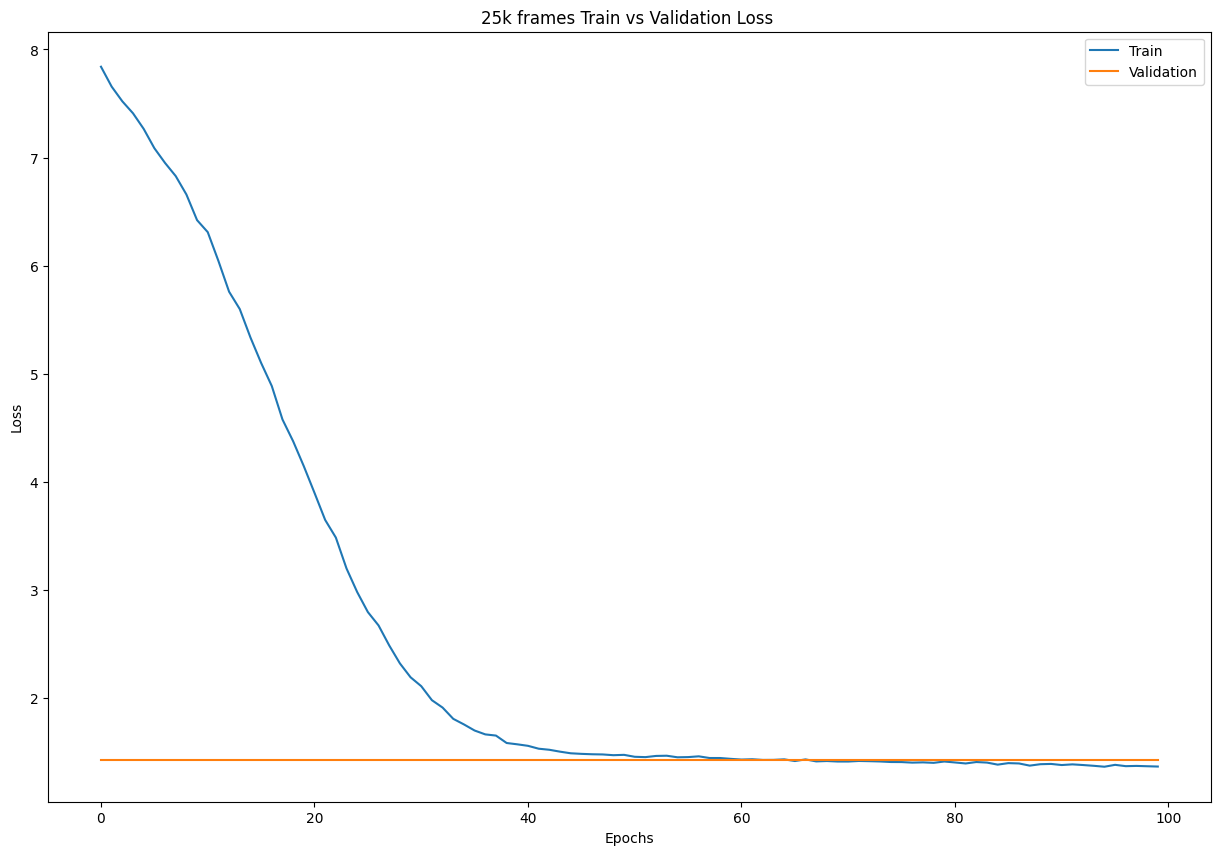

In [37]:
# plotting the losses
# Initial comparision between train and validation losses
plt.figure(figsize=(15,10))
plt.plot(total_train_losses, label='Train')
plt.plot(total_val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('25k frames Train vs Validation Loss ')
plt.savefig('6.png')
plt.show()

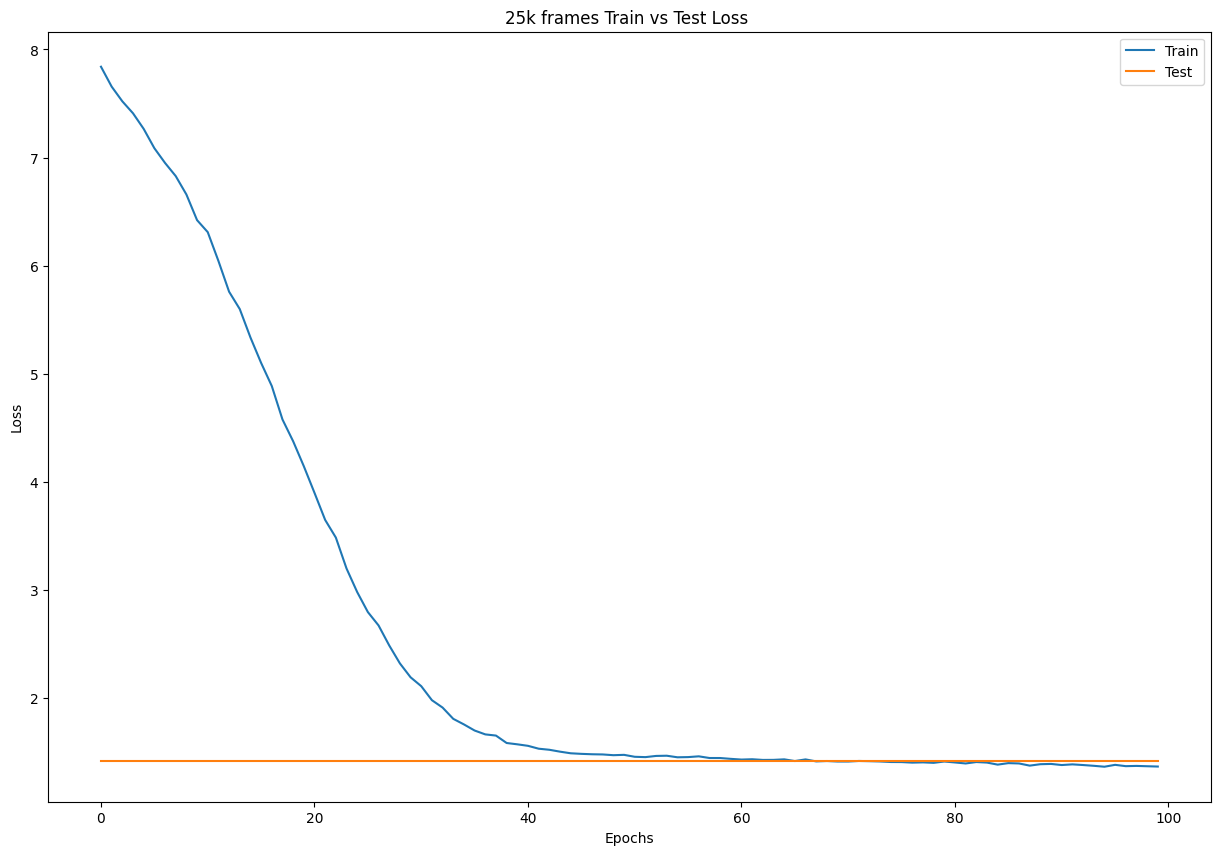

In [38]:
# comparision between train and test losses
plt.figure(figsize=(15,10))
plt.plot(total_train_losses, label='Train')
plt.plot(total_test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('25k frames Train vs Test Loss ')
plt.savefig('7.png')
plt.show()


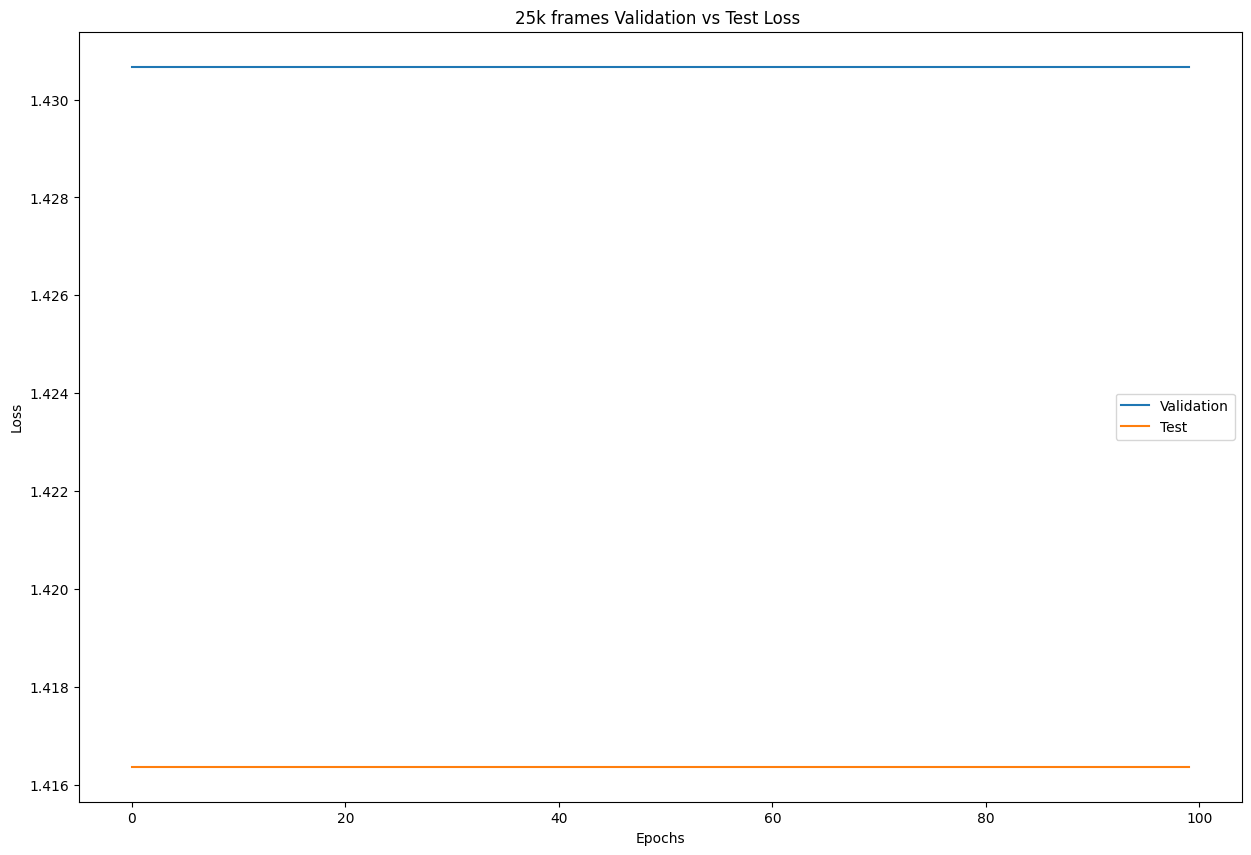

In [39]:
# validation vs test losses
plt.figure(figsize=(15,10))
plt.plot(total_val_losses, label='Validation')
plt.plot(total_test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('25k frames Validation vs Test Loss ')
plt.savefig('8.png')
plt.show()


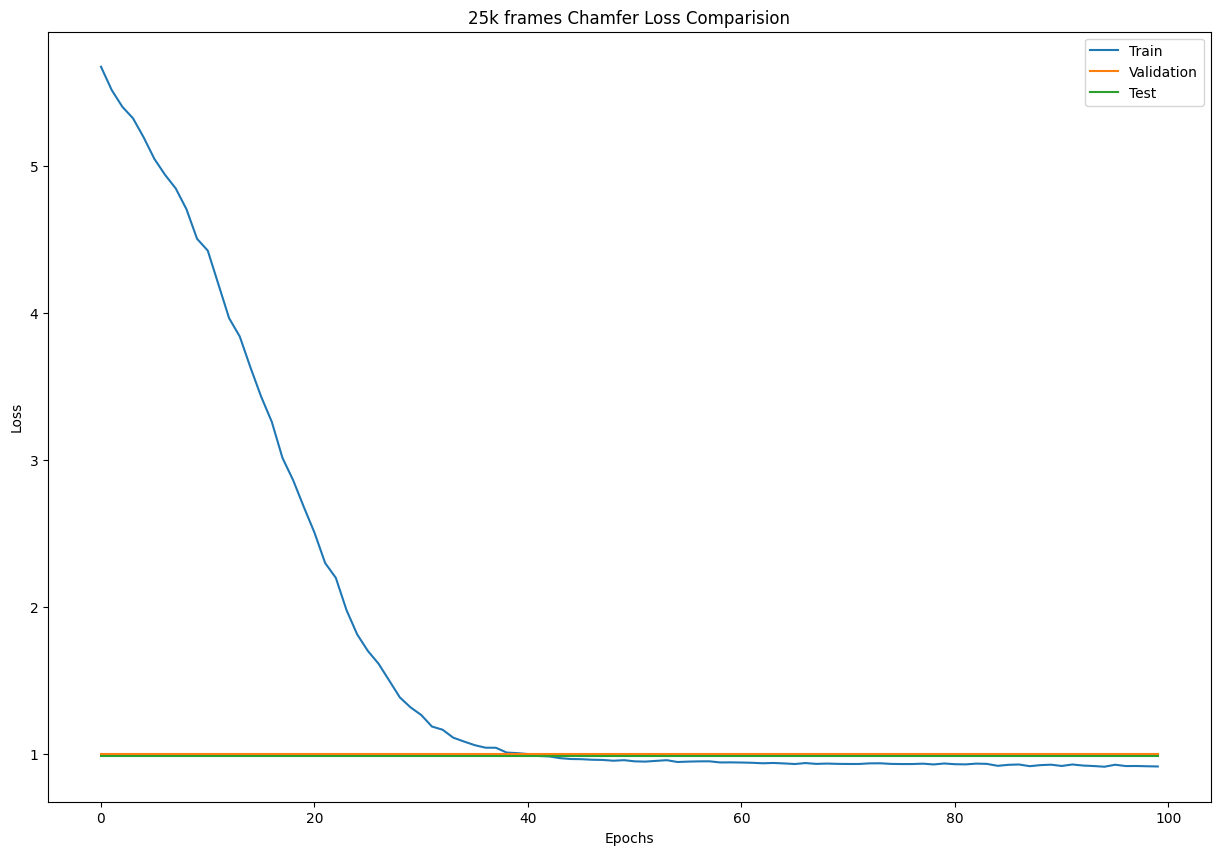

In [40]:
# Chamfer Loss Comparision in all three cases
plt.figure(figsize=(15,10))
plt.plot(closs_train_losses, label='Train')
plt.plot(closs_val_losses, label='Validation')
plt.plot(closs_test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('25k frames Chamfer Loss Comparision')
plt.savefig('9.png')
plt.show()


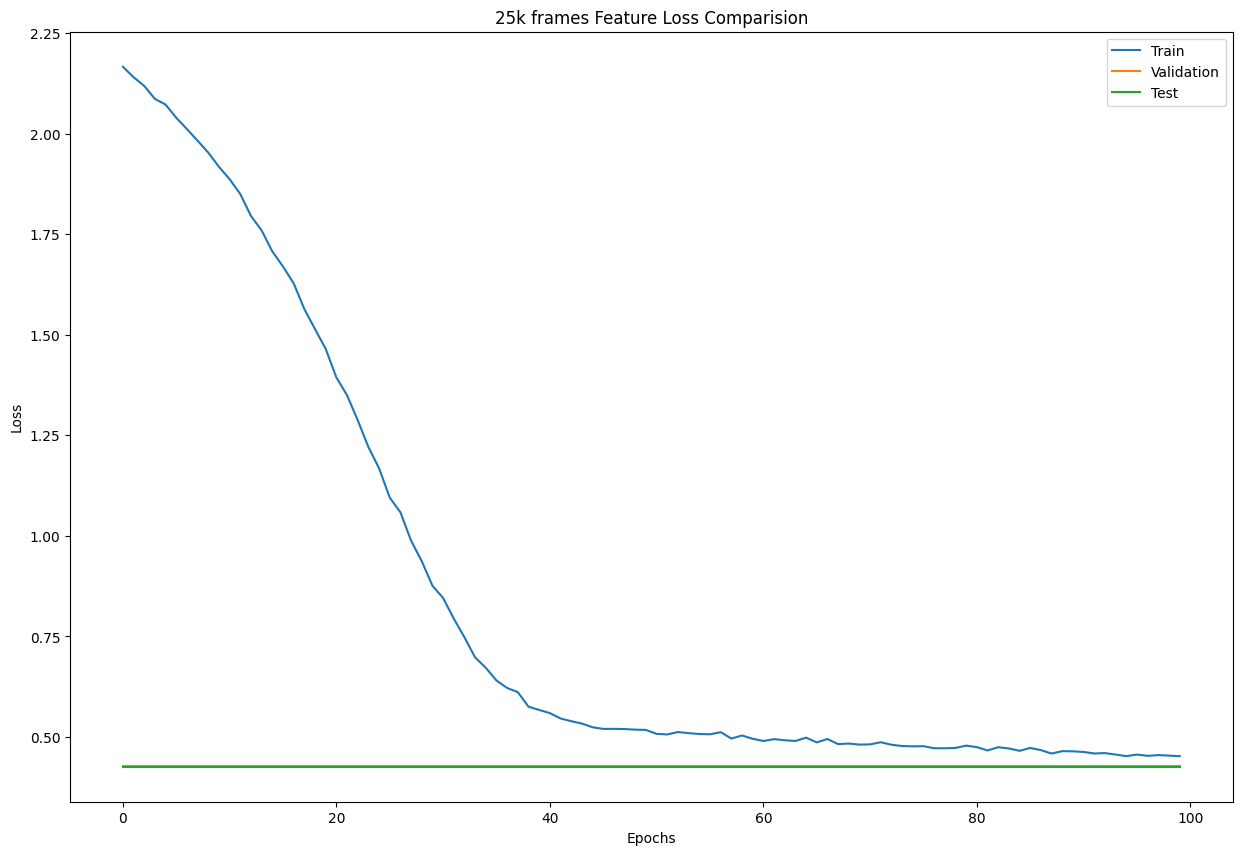

In [41]:
# Feature Loss Comparision in all three cases
plt.figure(figsize=(15,10))
plt.plot(feature_train_losses, label='Train')
plt.plot(feature_val_losses, label='Validation')
plt.plot(feature_test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('25k frames Feature Loss Comparision')
plt.savefig('10.png')
plt.show()


In [43]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graphs_device = []
for graph in tqdm(graphs):
    graphs_device.append(graph.to(device))

100%|██████████| 50/50 [00:00<00:00, 46274.32it/s]


from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

# change code to resolve error
for data in test_loader_set:
    z,encoded_edge_index = model.encode(data.x.float(), data.edge_index)
    decoded_x, decoded_edge_index = model.decode(z.float(), encoded_edge_index.float())
    heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(data.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], data.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

    # print("Error" , Error_wo_s, Error_af_s)

print("Average Error", avg1/len(test_loader_set))


In [55]:
# test function 
embeddings =[]
input_feature=[]
decoded_feature=[]
def error_calc():
    model.eval()
    for data in test_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        embeddings.append(z)
        decoded_feature.append(decoded_x)
        input_feature.append(data.x)
        heavy_indices = torch.where(data.x[:,4]>torch.tensor([1]).to(device))
        error=F.mse_loss(decoded_x[heavy_indices].float(), data.x[heavy_indices].float()).detach().cpu().numpy()
        avg1+=error
        avg_error=avg1/len(test_loader_set)
    return avg_error

In [56]:
avg_error=error_calc()

RuntimeError: expected scalar type Float but found Double

In [ ]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]